In [ ]:
#https://link.springer.com/article/10.1007/s10044-020-00898-1
#Long short term memory (LSTM) and Temporal convolutional networks (TCN) specialised Models for weather predictions
#

In [46]:
import pandas as pd
from datetime import datetime, date, time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import set_config
import matplotlib.pyplot as plt
set_config(display="diagram")


import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense

In [10]:
pd.set_option('display.max_columns',None)

In [2]:
df_weather = pd.read_pickle('weatherdata')

In [3]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35063 entries, 16079 to 51141
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   time_now            35063 non-null  datetime64[ns]
 1   temp_now            35063 non-null  float64       
 2   rhum_now            35063 non-null  float64       
 3   dwpt_now            35063 non-null  float64       
 4   pres_now            35063 non-null  float64       
 5   temp_diff           35063 non-null  float64       
 6   rhum_diff           35063 non-null  float64       
 7   dwpt_diff           35063 non-null  float64       
 8   pres_diff           35063 non-null  float64       
 9   tsun_now            34682 non-null  float64       
 10  prcp_now            35063 non-null  float64       
 11  snow_now            35063 non-null  float64       
 12  coco_now            35062 non-null  float64       
 13  tsun_now_next_hour  34682 non-null  float6

## Classifiing current weather conditions
based on current humiditiy dewpoint temperature and pressure and current month

In [32]:
df = df_weather[['date_now','month','temp_now','rhum_now','dwpt_now','pres_now','coco_now']]

In [33]:
#train-test-split
df_train = df[df.date_now <= date(2021,11,30)]
df_test = df[df.date_now > date(2021,11,30)].dropna()

In [34]:
x_train = df_train.drop(['date_now','coco_now'],axis=1)
y_train = df_train.coco_now
x_test = df_test.drop(['coco_now','date_now'],axis=1)
y_test = df_test.coco_now

In [35]:
features = list(x_train.columns)
features

['month', 'temp_now', 'rhum_now', 'dwpt_now', 'pres_now']

In [36]:
#Preprocessing Pipeline: Impute missing values
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features)
    ]
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['month', 'temp_now', 'rhum_now', 'dwpt_now',
                                  'pres_now'])])

In [37]:
cla = Pipeline(
    steps=[('preprocessor',preprocessor),('knn',SVC())]
)
cla

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['month', 'temp_now',
                                                   'rhum_now', 'dwpt_now',
                                                   'pres_now'])])),
                ('knn', SVC())])

In [38]:
cla.fit(x_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['month', 'temp_now',
                                                   'rhum_now', 'dwpt_now',
                                                   'pres_now'])])),
                ('knn', SVC())])

In [39]:
cla.score(x_test,y_test)

0.5028528901017117

In [42]:
predictions = cla.predict(x_test)

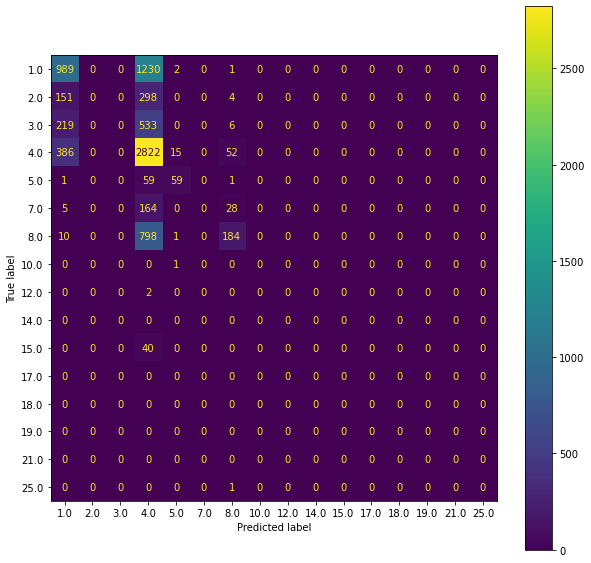

In [49]:
cm = confusion_matrix(y_test, predictions, labels=cla.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cla.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

## Classifing current weather conditions
based on the weather of the last 5 hours and using LSTM
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [64]:
df = df_weather[['time_now','temp_now','rhum_now','dwpt_now','pres_now','coco_now']]
df

,time_now,temp_now,rhum_now,dwpt_now,pres_now,coco_now
16079,2018-11-02 00:00:00,9.3,89.0,7.6,1017.4,4.0
16080,2018-11-02 01:00:00,7.8,91.0,6.4,1018.0,3.0
16081,2018-11-02 02:00:00,7.2,94.0,6.3,1018.3,2.0
16082,2018-11-02 03:00:00,7.0,93.0,5.9,1018.6,1.0
16083,2018-11-02 04:00:00,7.0,92.0,5.8,1019.5,4.0
...,...,...,...,...,...,...
51137,2022-11-01 18:00:00,10.6,82.0,7.7,1021.9,1.0
51138,2022-11-01 19:00:00,11.4,81.0,8.3,1022.1,1.0
51139,2022-11-01 20:00:00,10.9,83.0,8.1,1022.0,1.0
51140,2022-11-01 21:00:00,10.3,87.0,8.2,1022.6,1.0


In [65]:
#values = df.drop(['time_now'],axis=1).values
#scaler = MinMaxScaler(feature_range=(0,1))
#scaled = scaler.fit_transform(values)

In [66]:
#https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
# convert series to supervised learning
def series_to_supervised(data, n_in=5, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = pd.concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg

In [67]:
reframed = series_to_supervised(df, 5)

In [68]:
reframed

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
16084,2018-11-02 00:00:00,9.3,89.0,7.6,1017.4,4.0,2018-11-02 01:00:00,7.8,91.0,6.4,1018.0,3.0,2018-11-02 02:00:00,7.2,94.0,6.3,1018.3,2.0,2018-11-02 03:00:00,7.0,93.0,5.9,1018.6,1.0,2018-11-02 04:00:00,7.0,92.0,5.8,1019.5,4.0,2018-11-02 05:00:00,6.7,94.0,5.8,1020.0,1.0
16085,2018-11-02 01:00:00,7.8,91.0,6.4,1018.0,3.0,2018-11-02 02:00:00,7.2,94.0,6.3,1018.3,2.0,2018-11-02 03:00:00,7.0,93.0,5.9,1018.6,1.0,2018-11-02 04:00:00,7.0,92.0,5.8,1019.5,4.0,2018-11-02 05:00:00,6.7,94.0,5.8,1020.0,1.0,2018-11-02 06:00:00,5.5,97.0,5.1,1020.7,1.0
16086,2018-11-02 02:00:00,7.2,94.0,6.3,1018.3,2.0,2018-11-02 03:00:00,7.0,93.0,5.9,1018.6,1.0,2018-11-02 04:00:00,7.0,92.0,5.8,1019.5,4.0,2018-11-02 05:00:00,6.7,94.0,5.8,1020.0,1.0,2018-11-02 06:00:00,5.5,97.0,5.1,1020.7,1.0,2018-11-02 07:00:00,6.3,94.0,5.4,1021.6,1.0
16087,2018-11-02 03:00:00,7.0,93.0,5.9,1018.6,1.0,2018-11-02 04:00:00,7.0,92.0,5.8,1019.5,4.0,2018-11-02 05:00:00,6.7,94.0,5.8,1020.0,1.0,2018-11-02 06:00:00,5.5,97.0,5.1,1020.7,1.0,2018-11-02 07:00:00,6.3,94.0,5.4,1021.6,1.0,2018-11-02 08:00:00,8.3,85.0,5.9,1022.5,1.0
16088,2018-11-02 04:00:00,7.0,92.0,5.8,1019.5,4.0,2018-11-02 05:00:00,6.7,94.0,5.8,1020.0,1.0,2018-11-02 06:00:00,5.5,97.0,5.1,1020.7,1.0,2018-11-02 07:00:00,6.3,94.0,5.4,1021.6,1.0,2018-11-02 08:00:00,8.3,85.0,5.9,1022.5,1.0,2018-11-02 09:00:00,9.7,79.0,6.2,1022.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51137,2022-11-01 13:00:00,17.2,61.0,9.6,1020.0,2.0,2022-11-01 14:00:00,17.7,60.0,9.8,1020.1,1.0,2022-11-01 15:00:00,16.9,61.0,9.3,1020.4,3.0,2022-11-01 16:00:00,15.4,63.0,8.4,1020.7,1.0,2022-11-01 17:00:00,13.4,70.0,8.0,1021.3,1.0,2022-11-01 18:00:00,10.6,82.0,7.7,1021.9,1.0
51138,2022-11-01 14:00:00,17.7,60.0,9.8,1020.1,1.0,2022-11-01 15:00:00,16.9,61.0,9.3,1020.4,3.0,2022-11-01 16:00:00,15.4,63.0,8.4,1020.7,1.0,2022-11-01 17:00:00,13.4,70.0,8.0,1021.3,1.0,2022-11-01 18:00:00,10.6,82.0,7.7,1021.9,1.0,2022-11-01 19:00:00,11.4,81.0,8.3,1022.1,1.0
51139,2022-11-01 15:00:00,16.9,61.0,9.3,1020.4,3.0,2022-11-01 16:00:00,15.4,63.0,8.4,1020.7,1.0,2022-11-01 17:00:00,13.4,70.0,8.0,1021.3,1.0,2022-11-01 18:00:00,10.6,82.0,7.7,1021.9,1.0,2022-11-01 19:00:00,11.4,81.0,8.3,1022.1,1.0,2022-11-01 20:00:00,10.9,83.0,8.1,1022.0,1.0
51140,2022-11-01 16:00:00,15.4,63.0,8.4,1020.7,1.0,2022-11-01 17:00:00,13.4,70.0,8.0,1021.3,1.0,2022-11-01 18:00:00,10.6,82.0,7.7,1021.9,1.0,2022-11-01 19:00:00,11.4,81.0,8.3,1022.1,1.0,2022-11-01 20:00:00,10.9,83.0,8.1,1022.0,1.0,2022-11-01 21:00:00,10.3,87.0,8.2,1022.6,1.0


In [81]:
#train-test-split
df_train = reframed[reframed['var1(t)'].dt.date <= date(2021,11,30)]
df_test = reframed[reframed['var1(t)'].dt.date > date(2021,11,30)].dropna()

In [82]:
dropvals = [
    'var1(t-5)', 'var6(t-5)',
    'var1(t-4)', 'var6(t-4)',
    'var1(t-3)', 'var6(t-3)',
    'var1(t-2)', 'var6(t-2)',
    'var1(t-1)', 'var6(t-1)',
    'var1(t)', 'var6(t)',
]

In [97]:
x_train = df_train.drop(dropvals,axis=1)
y_train = df_train['var6(t)']
x_test = df_test.drop(dropvals,axis=1)
y_test = df_test['var6(t)']

In [98]:
x_train

,var2(t-5),var3(t-5),var4(t-5),var5(t-5),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var2(t),var3(t),var4(t),var5(t)
16084,9.3,89.0,7.6,1017.4,7.8,91.0,6.4,1018.0,7.2,94.0,6.3,1018.3,7.0,93.0,5.9,1018.6,7.0,92.0,5.8,1019.5,6.7,94.0,5.8,1020.0
16085,7.8,91.0,6.4,1018.0,7.2,94.0,6.3,1018.3,7.0,93.0,5.9,1018.6,7.0,92.0,5.8,1019.5,6.7,94.0,5.8,1020.0,5.5,97.0,5.1,1020.7
16086,7.2,94.0,6.3,1018.3,7.0,93.0,5.9,1018.6,7.0,92.0,5.8,1019.5,6.7,94.0,5.8,1020.0,5.5,97.0,5.1,1020.7,6.3,94.0,5.4,1021.6
16087,7.0,93.0,5.9,1018.6,7.0,92.0,5.8,1019.5,6.7,94.0,5.8,1020.0,5.5,97.0,5.1,1020.7,6.3,94.0,5.4,1021.6,8.3,85.0,5.9,1022.5
16088,7.0,92.0,5.8,1019.5,6.7,94.0,5.8,1020.0,5.5,97.0,5.1,1020.7,6.3,94.0,5.4,1021.6,8.3,85.0,5.9,1022.5,9.7,79.0,6.2,1022.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43074,4.4,82.0,1.6,1012.0,4.4,86.0,2.3,1012.1,4.1,90.0,2.6,1012.3,4.4,89.0,2.7,1012.4,4.6,89.0,2.9,1012.7,4.7,90.0,3.2,1013.0
43075,4.4,86.0,2.3,1012.1,4.1,90.0,2.6,1012.3,4.4,89.0,2.7,1012.4,4.6,89.0,2.9,1012.7,4.7,90.0,3.2,1013.0,5.0,88.0,3.2,1012.7
43076,4.1,90.0,2.6,1012.3,4.4,89.0,2.7,1012.4,4.6,89.0,2.9,1012.7,4.7,90.0,3.2,1013.0,5.0,88.0,3.2,1012.7,5.2,87.0,3.2,1012.7
43077,4.4,89.0,2.7,1012.4,4.6,89.0,2.9,1012.7,4.7,90.0,3.2,1013.0,5.0,88.0,3.2,1012.7,5.2,87.0,3.2,1012.7,5.6,86.0,3.4,1012.4


In [99]:
# reshape input to be 3D [samples, timesteps, features]
train_X = x_train.values.reshape((x_train.shape[0], 1, x_train.shape[1]))
test_X = x_test.values.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(train_X.shape, y_train.shape, test_X.shape, y_test.shape)

(26995, 1, 24) (26995,) (8057, 1, 24) (8057,)


In [100]:
train_X[1]

array([[   7.8,   91. ,    6.4, 1018. ,    7.2,   94. ,    6.3, 1018.3,
           7. ,   93. ,    5.9, 1018.6,    7. ,   92. ,    5.8, 1019.5,
           6.7,   94. ,    5.8, 1020. ,    5.5,   97. ,    5.1, 1020.7]])

Epoch 1/50
375/375 - 4s - loss: 2.6478 - val_loss: 1.7998 - 4s/epoch - 10ms/step
Epoch 2/50
375/375 - 1s - loss: 1.7095 - val_loss: 1.6752 - 1s/epoch - 3ms/step
Epoch 3/50
375/375 - 1s - loss: 1.6497 - val_loss: 1.6750 - 1s/epoch - 3ms/step
Epoch 4/50
375/375 - 1s - loss: 1.6490 - val_loss: 1.6748 - 1s/epoch - 3ms/step
Epoch 5/50
375/375 - 1s - loss: 1.6495 - val_loss: 1.6750 - 1s/epoch - 3ms/step
Epoch 6/50
375/375 - 1s - loss: 1.6500 - val_loss: 1.6749 - 1s/epoch - 3ms/step
Epoch 7/50
375/375 - 1s - loss: 1.6497 - val_loss: 1.6749 - 1s/epoch - 3ms/step
Epoch 8/50
375/375 - 1s - loss: 1.6497 - val_loss: 1.6749 - 1s/epoch - 3ms/step
Epoch 9/50
375/375 - 1s - loss: 1.6497 - val_loss: 1.6749 - 1s/epoch - 3ms/step
Epoch 10/50
375/375 - 1s - loss: 1.6501 - val_loss: 1.6749 - 1s/epoch - 3ms/step
Epoch 11/50
375/375 - 1s - loss: 1.6499 - val_loss: 1.6751 - 1s/epoch - 3ms/step
Epoch 12/50
375/375 - 1s - loss: 1.6504 - val_loss: 1.6750 - 1s/epoch - 3ms/step
Epoch 13/50
375/375 - 1s - loss: 1.6

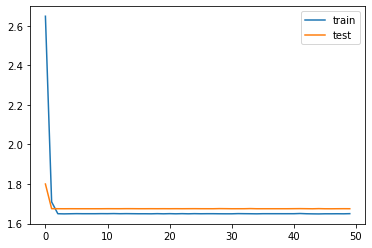

In [101]:
#designing the network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary
# fit network
history = model.fit(train_X, y_train, epochs=50, batch_size=72, validation_data=(test_X, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [88]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 50)                15000     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 15,051
Trainable params: 15,051
Non-trainable params: 0
_________________________________________________________________


In [102]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


252/252 [==============================] - 1s 1ms/step


In [103]:
yhat

array([[3.997625],
       [3.997625],
       [3.997625],
       ...,
       [3.997625],
       [3.997625],
       [3.997625]], dtype=float32)

In [57]:
x_test['prediction'] = yhat
x_test['actual'] = y_test

In [59]:
x_test.sample(10)

,var2(t-5),var3(t-5),var4(t-5),var5(t-5),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var2(t),var3(t),var4(t),var5(t),prediction,actual
49657,18.9,62.0,11.5,1019.3,18.3,64.0,11.4,1019.4,18.0,66.0,11.6,1019.6,17.8,67.0,11.6,1019.4,16.9,72.0,11.8,1019.1,15.8,78.0,12.0,1019.1,3.997681,1.0
46603,11.7,65.0,5.3,1016.8,10.8,69.0,5.3,1017.1,10.3,73.0,5.7,1017.7,9.1,82.0,6.2,1018.3,9.1,87.0,7.0,1018.9,8.8,93.0,7.7,1019.6,3.997681,8.0
48098,19.5,73.0,14.5,1021.0,17.9,80.0,14.4,1021.5,16.6,84.0,13.9,1021.9,15.2,89.0,13.4,1022.2,14.1,93.0,13.0,1022.4,13.6,93.0,12.5,1022.5,3.997681,1.0
51079,12.3,95.0,11.5,1019.9,12.2,98.0,11.9,1019.9,12.0,96.0,11.4,1020.0,11.3,99.0,11.1,1019.8,11.5,99.0,11.3,1020.1,14.0,87.0,11.9,1020.2,3.997681,1.0
49867,19.1,68.0,13.1,1012.4,15.8,81.0,12.5,1012.5,16.5,85.0,14.0,1013.1,16.8,83.0,13.9,1013.1,14.4,90.0,12.8,1014.3,14.5,93.0,13.4,1014.5,3.997681,8.0
50360,8.5,94.0,7.6,1009.4,7.4,96.0,6.8,1010.1,6.8,97.0,6.4,1010.9,6.5,99.0,6.4,1011.8,7.2,100.0,7.2,1012.2,8.1,95.0,7.3,1012.8,3.997681,5.0
44232,4.0,96.0,3.4,1036.9,3.9,99.0,3.8,1037.3,3.9,98.0,3.6,1037.0,3.9,97.0,3.5,1037.1,3.8,97.0,3.4,1037.2,3.8,96.0,3.2,1037.5,3.997681,4.0
48622,35.8,17.0,7.0,1013.8,33.5,22.0,8.9,1014.1,29.2,29.0,9.3,1014.4,22.7,47.0,10.8,1014.8,28.1,29.0,8.4,1014.7,30.1,25.0,7.9,1014.8,3.997681,1.0
50666,11.0,96.0,10.4,1022.6,9.9,97.0,9.4,1022.7,9.7,97.0,9.2,1022.7,9.9,96.0,9.3,1022.4,9.2,98.0,8.9,1022.4,9.5,99.0,9.4,1022.2,3.997681,4.0
50010,19.2,54.0,9.7,1009.0,19.5,52.0,9.4,1009.0,18.9,56.0,9.9,1009.1,18.6,58.0,10.2,1009.3,17.0,78.0,13.1,1009.6,16.8,75.0,12.3,1009.8,3.997681,4.0
